<a href="https://colab.research.google.com/github/peksikeksi/metal-surface-defect-classification-model/blob/master/metal_surface_defect_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
from datetime import datetime
import pathlib
import io
import os
import time
import random
import shutil
import tensorflow_probability as tfp
from PIL import Image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Layer, Concatenate, Lambda
from tensorflow.keras.layers import (Layer, GlobalAveragePooling2D, AveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense, Flatten,
                                     InputLayer, BatchNormalization, Input, RandomContrast, GaussianNoise, RandomContrast, Rescaling, Resizing, Reshape, RandomBrightness)
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, TopKCategoricalAccuracy, CategoricalAccuracy, F1Score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.data import AUTOTUNE

### Configuration Parameters

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
LEARNING_RATE = 1e-2
NUM_EPOCHS = 30
NUM_FILTERS = 6
KERNEL_SIZE = 3
STRIDES = 1
POOL_SIZE = 2
DENSE_UNITS_1 = 1024
DENSE_UNITS_2 = 128
NUM_CLASSES = 10
CLASS_NAMES = ['crease', 'crescent_gap', 'inclusion', 'oil_spot', 'punching_hole', 'rolled_pit', 'silk_spot', 'waist folding', 'water_spot', 'welding_line']
TRAIN_DIRECTORY = '/content/dataset/training_set'
VAL_DIRECTORY = '/content/dataset/validation_set'
TEST_DIRECTORY = '/content/dataset/test_set'

### Data Preparation and Preprocessing

In [3]:
# Install Kaggle API
!pip install -q kaggle

# Set up Kaggle credentials
!mkdir -p ~/.kaggle  # Create the hidden directory if it doesn't exist
!cp kaggle.json ~/.kaggle/  # Copy kaggle.json to the hidden directory
!chmod 600 ~/.kaggle/kaggle.json  # Set permissions for your user only

# Download and unzip the dataset
try:
    # Check if the dataset file exists before downloading
    if not os.path.exists('/content/defects-class-and-location'):
        !kaggle datasets download -d zhangyunsheng/defects-class-and-location

    # Check if the dataset directory exists before unzipping
    if not os.path.exists('/content/dataset'):
        !mkdir /content/dataset

    !unzip -q '/content/defects-class-and-location.zip' -d '/content/dataset/'

    print("Dataset downloaded and unzipped successfully.")
except Exception as e:
    print("Error:", e)

Dataset URL: https://www.kaggle.com/datasets/zhangyunsheng/defects-class-and-location
License(s): unknown
 99% 913M/923M [00:13<00:00, 65.4MB/s]
100% 923M/923M [00:13<00:00, 71.3MB/s]
Dataset downloaded and unzipped successfully.


In [4]:
# Define the path to your dataset
dataset_path = "/content/dataset/images/images"

# Initialize a dictionary to store the count of images per category
category_counts = {}
total_images = 0  # Initialize a counter for the total number of images

# Iterate through each category folder
for category_folder in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category_folder)

    if os.path.isdir(category_path):
        # Get list of image files in the current category
        image_files = os.listdir(category_path)
        # Count the number of images in the current category
        num_images = len([f for f in image_files if os.path.isfile(os.path.join(category_path, f))])

        # Store the count in the dictionary
        category_counts[category_folder] = num_images
        # Update the total image count
        total_images += num_images

# Create class weights dictionary
class_weights = {idx: 1 / count for idx, (category, count) in enumerate(category_counts.items())}

# Print the number of images in each category
for category, count in category_counts.items():
    print(f"Category: {category}, Number of images: {count}")

# Print the total number of images in the dataset
print(f"\n\nTotal number of images in the dataset: {total_images}\n\n")

# Determine if the dataset is balanced
min_images = min(category_counts.values())
max_images = max(category_counts.values())

if min_images == max_images:
    print("The dataset is perfectly balanced.")
else:
    print("The dataset is not balanced.")
    print(f"Smallest category has {min_images} images.")
    print(f"Largest category has {max_images} images.")

# Print the class weights
print("\n\nClass weights:")
for idx, weight in class_weights.items():
    print(f"Class {idx}: {weight}")

Category: silk_spot, Number of images: 650
Category: water_spot, Number of images: 289
Category: inclusion, Number of images: 216
Category: punching_hole, Number of images: 219
Category: crease, Number of images: 52
Category: oil_spot, Number of images: 204
Category: welding_line, Number of images: 273
Category: waist folding, Number of images: 146
Category: crescent_gap, Number of images: 226
Category: rolled_pit, Number of images: 31


Total number of images in the dataset: 2306


The dataset is not balanced.
Smallest category has 31 images.
Largest category has 650 images.


Class weights:
Class 0: 0.0015384615384615385
Class 1: 0.0034602076124567475
Class 2: 0.004629629629629629
Class 3: 0.0045662100456621
Class 4: 0.019230769230769232
Class 5: 0.004901960784313725
Class 6: 0.003663003663003663
Class 7: 0.00684931506849315
Class 8: 0.004424778761061947
Class 9: 0.03225806451612903


In [5]:
# Normalize class weights (optional step)
total_weight = sum(class_weights.values())
normalized_class_weights = {k: v / total_weight for k, v in class_weights.items()}

# Print normalized class weights
print("Normalized class weights:")
for idx, weight in normalized_class_weights.items():
    print(f"Class {idx}: {weight}")

Normalized class weights:
Class 0: 0.01798898912064259
Class 1: 0.04045966411217192
Class 2: 0.054133532076007795
Class 3: 0.05339197684208988
Class 4: 0.22486236400803242
Class 5: 0.05731785749224355
Class 6: 0.04283092647772046
Class 7: 0.08008796526313482
Class 8: 0.05173824304609595
Class 9: 0.3771884815618608


In [6]:
# Define paths to your dataset folders
dataset_path = "/content/dataset/images/images"
train_path = "/content/dataset/training_set"
validation_path = "/content/dataset/validation_set"
test_path = "/content/dataset/test_set"

# Define the target size for resizing images
target_size = (256, 256)

# Create train, validation, and test directories if they don't exist
os.makedirs(train_path, exist_ok=True)
os.makedirs(validation_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Define the ratios of data to be used for training, validation, and test
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

# Ensure the ratios sum to 1.0
assert train_ratio + validation_ratio + test_ratio == 1.0, "Ratios must sum to 1.0"

# Iterate through each category folder
for category_folder in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category_folder)
    train_category_path = os.path.join(train_path, category_folder)
    validation_category_path = os.path.join(validation_path, category_folder)
    test_category_path = os.path.join(test_path, category_folder)
    os.makedirs(train_category_path, exist_ok=True)
    os.makedirs(validation_category_path, exist_ok=True)
    os.makedirs(test_category_path, exist_ok=True)

    # Get list of image files in the current category
    image_files = os.listdir(category_path)
    # Shuffle the list of image files
    random.shuffle(image_files)

    # Calculate the number of images for each set
    num_train = int(len(image_files) * train_ratio)
    num_validation = int(len(image_files) * validation_ratio)
    num_test = len(image_files) - num_train - num_validation

    # Split the image files into train, validation, and test sets based on the defined ratios
    train_images = image_files[:num_train]
    validation_images = image_files[num_train:num_train + num_validation]
    test_images = image_files[num_train + num_validation:]

    # Function to resize and save images
    def resize_and_save(src, dst, size):
        with Image.open(src) as img:
            img = img.resize(size, Image.LANCZOS)
            img.save(dst)

    # Move and resize images to train directory
    for image_file in train_images:
        src = os.path.join(category_path, image_file)
        dst = os.path.join(train_category_path, image_file)
        resize_and_save(src, dst, target_size)

    # Move and resize images to validation directory
    for image_file in validation_images:
        src = os.path.join(category_path, image_file)
        dst = os.path.join(validation_category_path, image_file)
        resize_and_save(src, dst, target_size)

    # Move and resize images to test directory
    for image_file in test_images:
        src = os.path.join(category_path, image_file)
        dst = os.path.join(test_category_path, image_file)
        resize_and_save(src, dst, target_size)

print("Data preprocessing and splitting complete.")

Data preprocessing and splitting complete.


In [7]:
def check_image_size(image_path, expected_size):
    with Image.open(image_path) as img:
        actual_size = img.size
        assert actual_size == expected_size, f"Image {image_path} has size {actual_size} instead of {expected_size}"
        print(f"Image {image_path} has the correct size {actual_size}")

def get_first_image_path(folder_path):
    for category_folder in os.listdir(folder_path):
        category_path = os.path.join(folder_path, category_folder)
        if os.path.isdir(category_path):
            for image_file in os.listdir(category_path):
                return os.path.join(category_path, image_file)
    return None

# Check an image from the training set
train_image_path = get_first_image_path(train_path)
if train_image_path:
    check_image_size(train_image_path, target_size)
else:
    print("No images found in the training set.")

# Check an image from the validation set
validation_image_path = get_first_image_path(validation_path)
if validation_image_path:
    check_image_size(validation_image_path, target_size)
else:
    print("No images found in the validation set.")

# Check an image from the test set
test_image_path = get_first_image_path(test_path)
if test_image_path:
    check_image_size(test_image_path, target_size)
else:
    print("No images found in the test set.")

Image /content/dataset/training_set/silk_spot/img_05_4406743300_00516.jpg has the correct size (256, 256)
Image /content/dataset/validation_set/silk_spot/img_01_425005700_00325.jpg has the correct size (256, 256)
Image /content/dataset/test_set/silk_spot/img_05_4406743300_00405.jpg has the correct size (256, 256)


In [8]:
# Define data augmentation layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal_and_vertical', seed=42),  # Randomly flip images
    # tf.keras.layers.Rescaling(scale=1./255)
])

train_dataset = tf.keras.utils.image_dataset_from_directory(TRAIN_DIRECTORY,
                                                            labels='inferred',
                                                            label_mode='categorical',
                                                            class_names=CLASS_NAMES,
                                                            color_mode='rgb',
                                                            batch_size=BATCH_SIZE,
                                                            image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                            shuffle=True,
                                                            seed=42)

# Apply data augmentation to the training dataset
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))

Found 1610 files belonging to 10 classes.


In [9]:
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
# for image, label in train_dataset.take(1):
#     print("Image values:\n", image[0].numpy())
#     print("Label values:\n", label[0].numpy())

In [10]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(VAL_DIRECTORY,
                                                            labels='inferred',
                                                            label_mode='categorical',
                                                            class_names=CLASS_NAMES,
                                                            color_mode='rgb',
                                                            batch_size=BATCH_SIZE,
                                                            image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                            shuffle=True,
                                                            seed=42)

Found 339 files belonging to 10 classes.


In [11]:
test_dataset = tf.keras.utils.image_dataset_from_directory(TEST_DIRECTORY,
                                                            labels='inferred',
                                                            label_mode='categorical',
                                                            class_names=CLASS_NAMES,
                                                            color_mode='rgb',
                                                            batch_size=BATCH_SIZE,
                                                            image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                            shuffle=True,
                                                            seed=42)

Found 357 files belonging to 10 classes.


In [ ]:
def display_images_from_dataset(dataset, num_images):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  # Take a single batch from the dataset
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            if images.shape[-1] == 1:  # If grayscale, remove the last dimension
                plt.imshow(images[i].numpy().squeeze())
            else:
                plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(CLASS_NAMES[tf.argmax(labels[i])])
            plt.axis("off")
    plt.show()

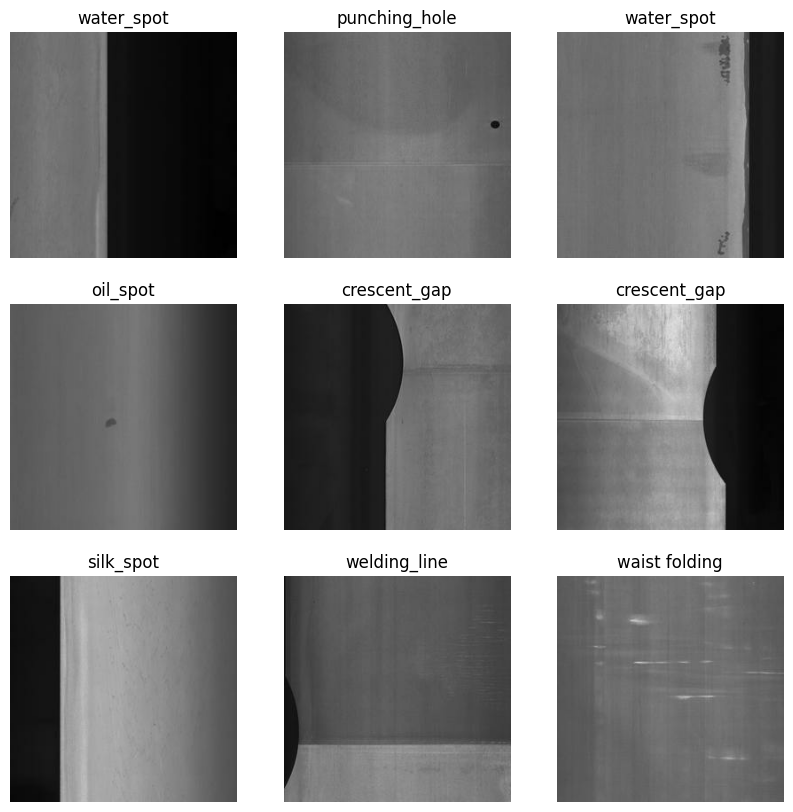

In [ ]:
# Display 9 images from the training set
display_images_from_dataset(train_dataset, num_images=9)

In [ ]:
# Prefetch the datasets for performance optimization
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

### Modeling

#### EfficientNetB5

In [ ]:
efficient_netB5 = tf.keras.applications.EfficientNetB5(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
)

efficient_netB5.trainable = False

115263384/115263384 [==============================] - 1s 0us/step


In [ ]:
input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = efficient_netB5(input, training=False)

x = GlobalAveragePooling2D()(x)
x = Dense(DENSE_UNITS_1, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(DENSE_UNITS_2, activation='relu')(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

efficient_netB5_model = Model(input, output)

efficient_netB5_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb5 (Functional  (None, 8, 8, 2048)        28513527  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                             

In [ ]:
plateau_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1)

loss_function = CategoricalCrossentropy(from_logits=False)

metrics = [CategoricalAccuracy(name='accuracy'), TopKCategoricalAccuracy(k=2, name='top_k_accuracy'), F1Score(name='f1_score')]

In [ ]:
efficient_netB5_model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss = loss_function,
    metrics = metrics
)

In [ ]:
history_enB5 = efficient_netB5_model.fit(train_dataset,
                                    validation_data=validation_dataset,
                                    epochs=NUM_EPOCHS,
                                    class_weight=class_weights,
                                    callbacks=[plateau_callback],
                                    verbose=1)

Epoch 1/30
51/51 [==============================] - 46s 461ms/step - loss: 0.0211 - accuracy: 0.5441 - top_k_accuracy: 0.7236 - f1_score: 0.4189 - val_loss: 22.1256 - val_accuracy: 0.3451 - val_top_k_accuracy: 0.5516 - val_f1_score: 0.1325 - lr: 0.0100
Epoch 2/30
51/51 [==============================] - 16s 301ms/step - loss: 0.0063 - accuracy: 0.6689 - top_k_accuracy: 0.8503 - f1_score: 0.5722 - val_loss: 2.7759 - val_accuracy: 0.6490 - val_top_k_accuracy: 0.8702 - val_f1_score: 0.5158 - lr: 0.0100
Epoch 3/30
51/51 [==============================] - 16s 302ms/step - loss: 0.0049 - accuracy: 0.7068 - top_k_accuracy: 0.8758 - f1_score: 0.6027 - val_loss: 1.7504 - val_accuracy: 0.6755 - val_top_k_accuracy: 0.8702 - val_f1_score: 0.5865 - lr: 0.0100
Epoch 4/30
51/51 [==============================] - 16s 309ms/step - loss: 0.0036 - accuracy: 0.7559 - top_k_accuracy: 0.9062 - f1_score: 0.6701 - val_loss: 1.3705 - val_accuracy: 0.6932 - val_top_k_accuracy: 0.8997 - val_f1_score: 0.6055 - lr

In [ ]:
efficient_netB5_model.save_weights('weights_ENB5.h5')

##### Finetune

In [ ]:
# Load the weights saved after the initial transfer learning phase
efficient_netB5_model.load_weights('weights_ENB5.h5')

# Unfreeze the layers for fine-tuning
efficient_netB5.trainable = True

fine_tune_at = int(len(efficient_netB5.layers) * 0.8)  # Unfreeze top 20% of layers

for layer in efficient_netB5.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
efficient_netB5_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=loss_function,
    metrics=metrics
)

# Fine-tune the model
history_fine_tune = efficient_netB5_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=NUM_EPOCHS,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/30
51/51 [==============================] - 65s 561ms/step - loss: 0.0012 - accuracy: 0.9025 - top_k_accuracy: 0.9713 - f1_score: 0.8814 - val_loss: 0.6849 - val_accuracy: 0.8466 - val_top_k_accuracy: 0.9322 - val_f1_score: 0.7720
Epoch 2/30
51/51 [==============================] - 21s 407ms/step - loss: 0.0010 - accuracy: 0.9211 - top_k_accuracy: 0.9876 - f1_score: 0.9131 - val_loss: 0.6989 - val_accuracy: 0.8407 - val_top_k_accuracy: 0.9351 - val_f1_score: 0.7664
Epoch 3/30
51/51 [==============================] - 21s 406ms/step - loss: 9.9366e-04 - accuracy: 0.9211 - top_k_accuracy: 0.9839 - f1_score: 0.9089 - val_loss: 0.6237 - val_accuracy: 0.8525 - val_top_k_accuracy: 0.9410 - val_f1_score: 0.7909
Epoch 4/30
51/51 [==============================] - 22s 407ms/step - loss: 8.7543e-04 - accuracy: 0.9335 - top_k_accuracy: 0.9851 - f1_score: 0.9269 - val_loss: 0.6423 - val_accuracy: 0.8525 - val_top_k_accuracy: 0.9351 - val_f1_score: 0.7925
Epoch 5/30
51/51 [==================

In [ ]:
efficient_netB5_model.save_weights('fine_tuned_weights_ENB5.h5')

#### ResnNet50V2

In [ ]:
resnet_50v2 = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
)

resnet_50v2.trainable = False

94668760/94668760 [==============================] - 0s 0us/step


In [ ]:
input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = resnet_50v2(input, training=False)

x = GlobalAveragePooling2D()(x)
x = Dense(DENSE_UNITS_1, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(DENSE_UNITS_2, activation='relu')(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

resnet_50v2_model = Model(input, output)

resnet_50v2_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 1024)              2098176   
                                                                 
 batch_normalization_1 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 128)               1312

In [ ]:
resnet_50v2_model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss = loss_function,
    metrics = metrics
)

In [ ]:
# Define the preprocessing function for resnets
def preprocess_resnet(image, label):
    image = tf.keras.applications.resnet_v2.preprocess_input(image)
    return image, label

In [ ]:
history_rn50 = resnet_50v2_model.fit(train_dataset.map(preprocess_resnet, num_parallel_calls=AUTOTUNE),
                                    validation_data=validation_dataset.map(preprocess_resnet, num_parallel_calls=AUTOTUNE),
                                    epochs=NUM_EPOCHS,
                                    callbacks=[plateau_callback],
                                    class_weight=class_weights,
                                    verbose=1)

Epoch 1/30
51/51 [==============================] - 20s 240ms/step - loss: 0.0167 - accuracy: 0.6049 - top_k_accuracy: 0.7717 - f1_score: 0.4853 - val_loss: 9.1843 - val_accuracy: 0.5192 - val_top_k_accuracy: 0.6962 - val_f1_score: 0.3125 - lr: 0.0100
Epoch 2/30
51/51 [==============================] - 8s 153ms/step - loss: 0.0063 - accuracy: 0.6677 - top_k_accuracy: 0.8571 - f1_score: 0.5473 - val_loss: 2.3655 - val_accuracy: 0.6490 - val_top_k_accuracy: 0.8230 - val_f1_score: 0.5382 - lr: 0.0100
Epoch 3/30
51/51 [==============================] - 8s 161ms/step - loss: 0.0047 - accuracy: 0.7093 - top_k_accuracy: 0.8807 - f1_score: 0.6253 - val_loss: 1.0055 - val_accuracy: 0.6962 - val_top_k_accuracy: 0.8761 - val_f1_score: 0.5861 - lr: 0.0100
Epoch 4/30
51/51 [==============================] - 8s 149ms/step - loss: 0.0039 - accuracy: 0.7534 - top_k_accuracy: 0.9186 - f1_score: 0.6641 - val_loss: 0.7846 - val_accuracy: 0.7906 - val_top_k_accuracy: 0.9145 - val_f1_score: 0.6937 - lr: 0.

In [ ]:
resnet_50v2_model.save_weights('weights_RN50.h5')

##### Finetunning

In [ ]:
# Load the weights saved after the initial transfer learning phase
resnet_50v2_model.load_weights('weights_RN50.h5')

# Unfreeze the layers for fine-tuning
resnet_50v2.trainable = True

fine_tune_at = int(len(resnet_50v2.layers) * 0.8)  # Unfreeze top 20% of layers

for layer in resnet_50v2.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
resnet_50v2_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=loss_function,
    metrics=metrics
)

# Fine-tune the model
history_fine_tune = resnet_50v2_model.fit(
    train_dataset.map(preprocess_resnet, num_parallel_calls=AUTOTUNE),
    validation_data=validation_dataset.map(preprocess_resnet, num_parallel_calls=AUTOTUNE),
    epochs=NUM_EPOCHS,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/30
51/51 [==============================] - 24s 244ms/step - loss: 8.2646e-04 - accuracy: 0.9215 - top_k_accuracy: 0.9831 - f1_score: 0.9066 - val_loss: 0.7222 - val_accuracy: 0.8053 - val_top_k_accuracy: 0.9410 - val_f1_score: 0.7284
Epoch 2/30
51/51 [==============================] - 11s 216ms/step - loss: 8.0373e-04 - accuracy: 0.9391 - top_k_accuracy: 0.9907 - f1_score: 0.9355 - val_loss: 0.7801 - val_accuracy: 0.8260 - val_top_k_accuracy: 0.9410 - val_f1_score: 0.7558
Epoch 3/30
51/51 [==============================] - 10s 191ms/step - loss: 7.5856e-04 - accuracy: 0.9497 - top_k_accuracy: 0.9925 - f1_score: 0.9445 - val_loss: 0.8351 - val_accuracy: 0.8230 - val_top_k_accuracy: 0.9292 - val_f1_score: 0.7338
Epoch 4/30
51/51 [==============================] - 10s 190ms/step - loss: 7.2878e-04 - accuracy: 0.9516 - top_k_accuracy: 0.9925 - f1_score: 0.9412 - val_loss: 0.8235 - val_accuracy: 0.8112 - val_top_k_accuracy: 0.9440 - val_f1_score: 0.7331
Epoch 5/30
51/51 [==========

In [ ]:
efficient_netB5_model.save_weights('fine_tuned_weights_RN50.h5')

#### InceptionV3

In [ ]:
inception_v3 = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
)

inception_v3.trainable = False

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = inception_v3(input, training=False)

x = GlobalAveragePooling2D()(x)
x = Dense(DENSE_UNITS_1, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(DENSE_UNITS_2, activation='relu')(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

inception_v3_model = Model(input, output)

inception_v3_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 1024)              2098176   
                                                                 
 batch_normalization_96 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                                 
 dense_7 (Dense)             (None, 128)               1312

In [ ]:
inception_v3_model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss = loss_function,
    metrics = metrics
)

In [ ]:
# Define the preprocessing function for inception
def preprocess_inception(image, label):
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image, label

In [ ]:
history_inc = inception_v3_model.fit(train_dataset.map(preprocess_inception, num_parallel_calls=AUTOTUNE),
                                    validation_data=validation_dataset.map(preprocess_inception, num_parallel_calls=AUTOTUNE),
                                    epochs=NUM_EPOCHS,
                                    class_weight=class_weights,
                                    callbacks=[plateau_callback],
                                    verbose=1)

Epoch 1/30
51/51 [==============================] - 23s 282ms/step - loss: 0.0179 - accuracy: 0.5700 - top_k_accuracy: 0.7368 - f1_score: 0.4405 - val_loss: 6.5207 - val_accuracy: 0.5546 - val_top_k_accuracy: 0.7050 - val_f1_score: 0.3995 - lr: 0.0100
Epoch 2/30
51/51 [==============================] - 7s 140ms/step - loss: 0.0070 - accuracy: 0.6161 - top_k_accuracy: 0.8149 - f1_score: 0.4905 - val_loss: 1.8287 - val_accuracy: 0.5959 - val_top_k_accuracy: 0.7611 - val_f1_score: 0.5150 - lr: 0.0100
Epoch 3/30
51/51 [==============================] - 8s 150ms/step - loss: 0.0057 - accuracy: 0.6665 - top_k_accuracy: 0.8478 - f1_score: 0.5511 - val_loss: 0.9511 - val_accuracy: 0.7316 - val_top_k_accuracy: 0.8761 - val_f1_score: 0.6262 - lr: 0.0100
Epoch 4/30
51/51 [==============================] - 7s 130ms/step - loss: 0.0051 - accuracy: 0.7031 - top_k_accuracy: 0.8851 - f1_score: 0.6209 - val_loss: 1.2186 - val_accuracy: 0.7050 - val_top_k_accuracy: 0.8201 - val_f1_score: 0.6030 - lr: 0.

In [ ]:
inception_v3_model.save_weights('weights_inception.h5')

##### Finetunning

In [ ]:
# Load the weights saved after the initial transfer learning phase
inception_v3_model.load_weights('weights_inception.h5')

# Unfreeze the layers for fine-tuning
inception_v3.trainable = True

fine_tune_at = int(len(inception_v3.layers) * 0.8)  # Unfreeze top 20% of layers

for layer in inception_v3.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
inception_v3_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=loss_function,
    metrics=metrics
)

# Fine-tune the model
history_fine_tune = inception_v3_model.fit(
    train_dataset.map(preprocess_inception, num_parallel_calls=AUTOTUNE),
    validation_data=validation_dataset.map(preprocess_inception, num_parallel_calls=AUTOTUNE),
    epochs=NUM_EPOCHS,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/30
51/51 [==============================] - 22s 192ms/step - loss: 0.0013 - accuracy: 0.8933 - top_k_accuracy: 0.9723 - f1_score: 0.8685 - val_loss: 0.6990 - val_accuracy: 0.8053 - val_top_k_accuracy: 0.9086 - val_f1_score: 0.7612
Epoch 2/30
51/51 [==============================] - 8s 151ms/step - loss: 9.3905e-04 - accuracy: 0.9280 - top_k_accuracy: 0.9839 - f1_score: 0.9217 - val_loss: 0.6880 - val_accuracy: 0.8083 - val_top_k_accuracy: 0.9145 - val_f1_score: 0.7617
Epoch 3/30
51/51 [==============================] - 8s 154ms/step - loss: 0.0010 - accuracy: 0.9298 - top_k_accuracy: 0.9839 - f1_score: 0.9170 - val_loss: 0.7130 - val_accuracy: 0.8171 - val_top_k_accuracy: 0.9145 - val_f1_score: 0.7147
Epoch 4/30
51/51 [==============================] - 9s 162ms/step - loss: 7.3346e-04 - accuracy: 0.9466 - top_k_accuracy: 0.9894 - f1_score: 0.9394 - val_loss: 0.7116 - val_accuracy: 0.8201 - val_top_k_accuracy: 0.9086 - val_f1_score: 0.7644
Epoch 5/30
51/51 [=====================

In [ ]:
efficient_netB5_model.save_weights('fine_tuned_weights_inception.h5')

#### MobileNet

In [ ]:
mobile_net_v2 = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
)

mobile_net_v2.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = mobile_net_v2(input, training=False)

x = GlobalAveragePooling2D()(x)
x = Dense(DENSE_UNITS_1, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(DENSE_UNITS_2, activation='relu')(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

mobile_net_v2_model = Model(input, output)

mobile_net_v2_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_9 (Dense)             (None, 1024)              1311744   
                                                                 
 batch_normalization_97 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                           

In [ ]:
mobile_net_v2_model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss = loss_function,
    metrics = metrics
)

In [ ]:
# Define the preprocessing function for mobilenet
def preprocess_mobile(image, label):
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

In [ ]:
history_mob = mobile_net_v2_model.fit(train_dataset.map(preprocess_mobile, num_parallel_calls=AUTOTUNE),
                                    validation_data=validation_dataset.map(preprocess_mobile, num_parallel_calls=AUTOTUNE),
                                    epochs=NUM_EPOCHS,
                                    class_weight=class_weights,
                                    callbacks=[plateau_callback],
                                    verbose=1)

Epoch 1/30
51/51 [==============================] - 14s 178ms/step - loss: 0.0174 - accuracy: 0.5906 - top_k_accuracy: 0.7445 - f1_score: 0.4724 - val_loss: 11.9956 - val_accuracy: 0.4543 - val_top_k_accuracy: 0.5280 - val_f1_score: 0.2227 - lr: 0.0100
Epoch 2/30
51/51 [==============================] - 5s 100ms/step - loss: 0.0069 - accuracy: 0.6379 - top_k_accuracy: 0.8211 - f1_score: 0.5076 - val_loss: 5.4760 - val_accuracy: 0.4867 - val_top_k_accuracy: 0.5929 - val_f1_score: 0.2262 - lr: 0.0100
Epoch 3/30
51/51 [==============================] - 7s 131ms/step - loss: 0.0047 - accuracy: 0.7068 - top_k_accuracy: 0.8783 - f1_score: 0.5859 - val_loss: 1.2830 - val_accuracy: 0.6844 - val_top_k_accuracy: 0.8702 - val_f1_score: 0.5442 - lr: 0.0100
Epoch 4/30
51/51 [==============================] - 6s 112ms/step - loss: 0.0041 - accuracy: 0.7317 - top_k_accuracy: 0.9087 - f1_score: 0.6301 - val_loss: 1.1710 - val_accuracy: 0.6932 - val_top_k_accuracy: 0.9027 - val_f1_score: 0.5846 - lr: 0

In [ ]:
mobile_net_v2_model.save_weights('weights_MN.h5')

##### Finetunning

In [ ]:
# Load the weights saved after the initial transfer learning phase
mobile_net_v2_model.load_weights('weights_MN.h5')

# Unfreeze the layers for fine-tuning
mobile_net_v2.trainable = True

fine_tune_at = int(len(mobile_net_v2.layers) * 0.8)  # Unfreeze top 20% of layers

for layer in mobile_net_v2.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
mobile_net_v2_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=loss_function,
    metrics=metrics
)

# Fine-tune the model
history_fine_tune = mobile_net_v2_model.fit(
    train_dataset.map(preprocess_mobile, num_parallel_calls=AUTOTUNE),
    validation_data=validation_dataset.map(preprocess_mobile, num_parallel_calls=AUTOTUNE),
    epochs=NUM_EPOCHS,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/30
51/51 [==============================] - 16s 121ms/step - loss: 0.0011 - accuracy: 0.8984 - top_k_accuracy: 0.9759 - f1_score: 0.8802 - val_loss: 0.9534 - val_accuracy: 0.7935 - val_top_k_accuracy: 0.9263 - val_f1_score: 0.7076
Epoch 2/30
51/51 [==============================] - 7s 127ms/step - loss: 0.0011 - accuracy: 0.9161 - top_k_accuracy: 0.9882 - f1_score: 0.9145 - val_loss: 1.1362 - val_accuracy: 0.7699 - val_top_k_accuracy: 0.9233 - val_f1_score: 0.7253
Epoch 3/30
51/51 [==============================] - 5s 96ms/step - loss: 0.0012 - accuracy: 0.9068 - top_k_accuracy: 0.9845 - f1_score: 0.9100 - val_loss: 0.8613 - val_accuracy: 0.8201 - val_top_k_accuracy: 0.9263 - val_f1_score: 0.7387
Epoch 4/30
51/51 [==============================] - 7s 125ms/step - loss: 0.0010 - accuracy: 0.9236 - top_k_accuracy: 0.9845 - f1_score: 0.9243 - val_loss: 0.9326 - val_accuracy: 0.7965 - val_top_k_accuracy: 0.9263 - val_f1_score: 0.7221
Epoch 5/30
51/51 [==============================

In [ ]:
mobile_net_v2_model.save_weights('fine_tuned_weights_MN.h5')

#### VGG19

In [ ]:
vgg19 = tf.keras.applications.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
)

vgg19.trainable = False

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = vgg19(input, training=False)

x = GlobalAveragePooling2D()(x)
x = Dense(DENSE_UNITS_1, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(DENSE_UNITS_2, activation='relu')(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

vgg19_model = Model(input, output)

vgg19_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 global_average_pooling2d_4  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 1024)              525312    
                                                                 
 batch_normalization_98 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                                 
 dense_13 (Dense)            (None, 128)               1312

In [ ]:
vgg19_model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss = loss_function,
    metrics = metrics
)

In [ ]:
# Define the preprocessing function for vgg
def preprocess_vgg(image, label):
    image = tf.keras.applications.vgg19.preprocess_input(image)
    return image, label

In [ ]:
history_vgg = vgg19_model.fit(train_dataset.map(preprocess_vgg, num_parallel_calls=AUTOTUNE),
                              validation_data=validation_dataset.map(preprocess_vgg, num_parallel_calls=AUTOTUNE),
                              epochs=NUM_EPOCHS,
                              class_weight=class_weights,
                              callbacks=[plateau_callback],
                              verbose=1)

Epoch 1/30
51/51 [==============================] - 35s 496ms/step - loss: 0.0165 - accuracy: 0.5972 - top_k_accuracy: 0.7660 - f1_score: 0.4732 - val_loss: 9.5818 - val_accuracy: 0.4513 - val_top_k_accuracy: 0.5428 - val_f1_score: 0.2259 - lr: 0.0100
Epoch 2/30
51/51 [==============================] - 15s 279ms/step - loss: 0.0064 - accuracy: 0.6621 - top_k_accuracy: 0.8441 - f1_score: 0.5590 - val_loss: 1.4307 - val_accuracy: 0.6903 - val_top_k_accuracy: 0.8437 - val_f1_score: 0.5300 - lr: 0.0100
Epoch 3/30
51/51 [==============================] - 14s 269ms/step - loss: 0.0054 - accuracy: 0.7155 - top_k_accuracy: 0.8752 - f1_score: 0.6276 - val_loss: 1.5865 - val_accuracy: 0.6342 - val_top_k_accuracy: 0.8348 - val_f1_score: 0.5334 - lr: 0.0100
Epoch 4/30
51/51 [==============================] - 15s 272ms/step - loss: 0.0045 - accuracy: 0.7366 - top_k_accuracy: 0.9043 - f1_score: 0.6663 - val_loss: 0.9103 - val_accuracy: 0.7080 - val_top_k_accuracy: 0.8732 - val_f1_score: 0.6148 - lr:

In [ ]:
vgg19_model.save_weights('weights_VGG.h5')

##### Finetunning

In [ ]:
# Load the weights saved after the initial transfer learning phase
vgg19_model.load_weights('weights_VGG.h5')

# Unfreeze the layers for fine-tuning
vgg19.trainable = True

fine_tune_at = int(len(vgg19.layers) * 0.8)  # Unfreeze top 20% of layers

for layer in vgg19.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
vgg19_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=loss_function,
    metrics=metrics
)

# Fine-tune the model
history_fine_tune = vgg19_model.fit(
    train_dataset.map(preprocess_vgg, num_parallel_calls=AUTOTUNE),
    validation_data=validation_dataset.map(preprocess_vgg, num_parallel_calls=AUTOTUNE),
    epochs=NUM_EPOCHS,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/30
51/51 [==============================] - 19s 303ms/step - loss: 0.0012 - accuracy: 0.8999 - top_k_accuracy: 0.9769 - f1_score: 0.8781 - val_loss: 0.7640 - val_accuracy: 0.8378 - val_top_k_accuracy: 0.9587 - val_f1_score: 0.7805
Epoch 2/30
51/51 [==============================] - 19s 364ms/step - loss: 9.9006e-04 - accuracy: 0.9248 - top_k_accuracy: 0.9894 - f1_score: 0.9234 - val_loss: 0.8061 - val_accuracy: 0.8201 - val_top_k_accuracy: 0.9410 - val_f1_score: 0.7592
Epoch 3/30
51/51 [==============================] - 16s 304ms/step - loss: 8.7945e-04 - accuracy: 0.9354 - top_k_accuracy: 0.9901 - f1_score: 0.9295 - val_loss: 0.7547 - val_accuracy: 0.8289 - val_top_k_accuracy: 0.9528 - val_f1_score: 0.7533
Epoch 4/30
51/51 [==============================] - 16s 302ms/step - loss: 8.7093e-04 - accuracy: 0.9373 - top_k_accuracy: 0.9919 - f1_score: 0.9235 - val_loss: 0.7301 - val_accuracy: 0.8407 - val_top_k_accuracy: 0.9469 - val_f1_score: 0.7835
Epoch 5/30
51/51 [==============

In [ ]:
vgg19_model.save_weights('fine_tuned_weights_VGG.h5')

### Evaluation

In [ ]:
print('EfficientNet B5:\n')
efficient_netB5_model.evaluate(test_dataset)
print('\nResNetV2:\n')
resnet_50v2_model.evaluate(test_dataset.map(preprocess_resnet, num_parallel_calls=AUTOTUNE))
print('\nInceptionV3:\n')
inception_v3_model.evaluate(test_dataset.map(preprocess_inception, num_parallel_calls=AUTOTUNE))
print('\nMobileNetV2:\n')
mobile_net_v2_model.evaluate(test_dataset.map(preprocess_mobile, num_parallel_calls=AUTOTUNE))
print('\nVGG19:\n')
vgg19_model.evaluate(test_dataset.map(preprocess_vgg, num_parallel_calls=AUTOTUNE))

EfficientNet B5:

12/12 [==============================] - 3s 233ms/step - loss: 0.7602 - accuracy: 0.8375 - top_k_accuracy: 0.9664 - f1_score: 0.7776

ResNetV2:

12/12 [==============================] - 2s 103ms/step - loss: 0.7175 - accuracy: 0.8515 - top_k_accuracy: 0.9748 - f1_score: 0.7587

InceptionV3:

12/12 [==============================] - 1s 85ms/step - loss: 0.9060 - accuracy: 0.8039 - top_k_accuracy: 0.9384 - f1_score: 0.7230

MobileNetV2:

12/12 [==============================] - 1s 53ms/step - loss: 0.6935 - accuracy: 0.8459 - top_k_accuracy: 0.9608 - f1_score: 0.7843

VGG19:

12/12 [==============================] - 3s 180ms/step - loss: 0.6359 - accuracy: 0.8655 - top_k_accuracy: 0.9580 - f1_score: 0.7961


[0.6359126567840576,
 0.8655462265014648,
 0.9579831957817078,
 array([0.5333333 , 0.86956525, 0.8000001 , 0.8474576 , 0.835821  ,
        0.54545456, 0.97512436, 0.9090909 , 0.9195402 , 0.7252747 ],
       dtype=float32)]

### Ensembling

#### Creating a Subnetwork

In [ ]:
def preprocess_efficient(image):
    return tf.keras.applications.efficientnet.preprocess_input(image)

def preprocess_resnet(image):
    return tf.keras.applications.resnet_v2.preprocess_input(image)

def preprocess_inception(image):
    return tf.keras.applications.inception_v3.preprocess_input(image)

def preprocess_mobile(image):
    return tf.keras.applications.mobilenet_v2.preprocess_input(image)

def preprocess_vgg(image):
    return tf.keras.applications.vgg19.preprocess_input(image)

def create_subnetwork(preprocess_func, base_model):
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    preprocessed = Lambda(preprocess_func)(inputs)
    outputs = base_model(preprocessed)
    return Model(inputs, outputs)

efficient_netB5_subnet = create_subnetwork(preprocess_efficient, efficient_netB5_model)
resnet_50v2_subnet = create_subnetwork(preprocess_resnet, resnet_50v2_model)
inception_v3_subnet = create_subnetwork(preprocess_inception, inception_v3_model)
mobile_net_v2_subnet = create_subnetwork(preprocess_mobile, mobile_net_v2_model)
vgg19_subnet = create_subnetwork(preprocess_vgg, vgg19_model)

#### Averaging

In [ ]:
ensemble_inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

y1 = efficient_netB5_subnet(ensemble_inputs)
y2 = resnet_50v2_subnet(ensemble_inputs)
y3 = inception_v3_subnet(ensemble_inputs)
y4 = mobile_net_v2_subnet(ensemble_inputs)
y5 = vgg19_subnet(ensemble_inputs)

ensemble_output = (y1 + y2 + y3 + y4 + y5) / 5

ensemble_model_avg = Model(inputs=ensemble_inputs, outputs=ensemble_output)

In [ ]:
ensemble_model_avg.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss=loss_function,
    metrics=metrics
)

#### Weighted Averaging

In [ ]:
outputs = .2*y1 + .3*y2 + .1*y3 + .2*y4 + .2*y5

ensemble_model_wavg = Model(inputs=ensemble_inputs, outputs=outputs)

In [ ]:
ensemble_model_wavg.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss=loss_function,
    metrics=metrics
)

#### Stacking

In [ ]:
concatenated = Concatenate()([y1, y2, y3, y4, y5])
x = Dense(128, activation='relu')(concatenated)
x = Dense(NUM_CLASSES, activation='softmax')(x)

ensemble_model_stack = Model(inputs=ensemble_inputs, outputs=x)

In [ ]:
ensemble_model_stack.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss=loss_function,
    metrics=metrics
)

### Evaluation

In [ ]:
print('Ensemble Model Average:\n')
ensemble_model_avg.evaluate(test_dataset)
print('\nEnsemble Model Weighted Average:\n')
ensemble_model_wavg.evaluate(test_dataset)
print('\nEnsemble Model Stack:\n')
ensemble_model_stack.evaluate(test_dataset)

Ensemble Model Average:

12/12 [==============================] - 7s 584ms/step - loss: 0.3946 - accuracy: 0.8880 - top_k_accuracy: 0.9692 - f1_score: 0.8421

Ensemble Model Weighted Average:

12/12 [==============================] - 7s 590ms/step - loss: 0.3933 - accuracy: 0.8824 - top_k_accuracy: 0.9720 - f1_score: 0.8242

Ensemble Model Stack:

12/12 [==============================] - 16s 583ms/step - loss: 2.1978 - accuracy: 0.5462 - top_k_accuracy: 0.7759 - f1_score: 0.5653


[2.1978118419647217,
 0.5462185144424438,
 0.7759103775024414,
 array([0.0657277 , 0.6296297 , 0.5192307 , 0.88709676, 0.7794118 ,
        0.5       , 0.6511628 , 0.62809914, 0.5970149 , 0.39520958],
       dtype=float32)]

In [ ]:
from google.colab import files

In [12]:
save_path = '/content/drive/MyDrive/Colab Notebooks/Projects/Metallic Surface Defect Classification'

In [ ]:
ensemble_model_avg.save(save_path)

In [13]:
# Load the saved model
loaded_model = load_model(save_path)

In [15]:
predicted = []
labels = []

for im, label in test_dataset:
  predicted.append(loaded_model(im))
  labels.append(label.numpy())

print(np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))

[1 1 8 6 5 6 3 5 6 4 9 3 6 7 6 8 0 8 6 8 1 3 4 6 4 9 4 1 2 9 6 3 6 0 4 0 6
 4 1 2 9 9 4 3 9 6 2 6 1 0 4 6 6 6 9 6 6 6 7 1 6 8 4 8 6 3 8 3 5 7 6 8 4 7
 9 9 4 6 0 6 6 2 6 6 6 9 8 9 3 7 8 4 6 1 1 9 4 8 1 1 6 3 1 7 6 1 6 3 3 4 7
 4 3 8 6 4 3 9 3 9 6 6 8 8 3 1 1 6 1 6 6 1 9 8 2 6 6 6 2 1 8 4 4 9 9 8 9 2
 6 6 6 6 6 9 8 2 2 8 7 1 9 4 2 7 6 4 6 3 6 2 6 2 7 9 9 6 7 1 8 7 6 2 2 3 6
 8 3 8 4 6 7 3 6 8 8 2 9 7 8 7 1 7 8 0 6 9 1 4 2 4 9 3 4 2 8 6 7 6 4 9 6 9
 4 0 6 3 6 4 6 6 4 6 3 3 6 4 6 6 8 1 5 9 7 2 5 6 1 6 6 8 8 6 7 8 2 3 9 8 2
 3 1 6 6 6 6 6 1 9 6 6 1 1 8 2 6 9 8 1 7 2 9 0 8 7 6 9 2 6 1 9 1 0 9 4 8 4
 4 9 1 6 1 9 2 9 2 6 5 3 6 2 6 6 9 8 2 6 7 8 6 3 6 8 8 6 8 6 7 6 3 8 6 6 6
 2 8 3 6 6 6 2 6 4 3 8 6 2 2 4 2 1 9 2 9 1 3 9 3]
[1 1 8 6 5 6 3 5 6 4 9 3 6 7 6 8 0 8 6 8 9 3 4 6 4 9 4 1 2 9 6 3 6 0 4 0 6
 4 1 2 9 9 4 3 9 6 2 6 1 0 4 6 6 6 9 6 6 6 7 1 6 8 4 8 6 3 8 3 9 7 6 2 4 7
 9 9 4 6 0 6 6 2 6 6 6 9 8 9 3 7 8 4 6 1 1 9 4 8 1 1 6 3 1 7 6 1 6 3 3 4 7
 4 3 8 6 4 3 9 3 9 6 6 8 8 3 1 1 6 1 6 6 1 9 8 2 6

In [17]:
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

Text(0.5, 58.7222222222222, 'Predicted')

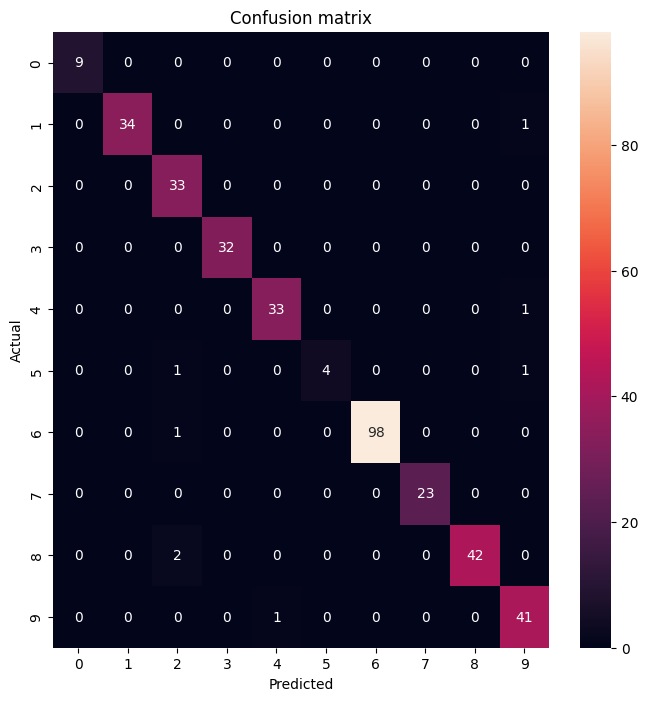

In [19]:
cm = confusion_matrix(lab, pred)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')